In [1]:
import os
from os.path import join as pjoin
from tifffile import imread, imwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter,median_filter
from NatMovie_utils import *
from wfield import *
from cor470 import enhance_df_f
sys.path.append('./ICA')
from jadeR import jadeR
from jadeR_cupy import jadeR_cupy


In [2]:
path_wfield = r'/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/moving-bar/process/20240708-191532-wfield'
experiment = os.path.basename(path_wfield)[:15]
mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
rawPath = pjoin(path_wfield,'..\\..\\raw')
path_out = pjoin(path_wfield, '..', experiment + '-mvbar')
os.makedirs(path_out, exist_ok=True)

direction_list=['right', 'down', 'left', 'up']
stim_len = 53 # bar=48 dots=138


In [6]:
if not os.path.exists(pjoin(path_wfield, "trials.csv")):
    n_frame = min(len(os.listdir(pjoin(rawPath, experiment + "-405"))),
                  len(os.listdir(pjoin(rawPath, experiment + "-470"))))
    stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
    stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
    stim_delay = int(stim_delay[0] / 10)
    stim = np.zeros(n_frame)
    for i in range(n_frame):
        stim[i] = stimfile[(i * 10 + stim_delay), 0]

    offset = np.where(np.diff(stim) == 1)[0] + 1
    onset = np.where(np.diff(stim) == -1)[0] + 1
    offset = offset[1:]
    offset = np.append(offset, onset[-1] + stim_len)
    trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset - onset), axis=1)
    np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
else:
    print("trials.csv of "+experiment+" has existed.")


trials.csv of 20240708-191532 has existed.


In [3]:
U = np.load(pjoin(path_wfield, 'U.npy')).astype('float32')
SVTcorr = np.load(pjoin(path_wfield, 'SVTcorr.npy')).astype('float32')
frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')
trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
seq = pd.read_csv('d4sequence.txt', header=None).values
tif_height,tif_width = U.shape[:2]


In [4]:
def sorting_4direct(SVT, trigger, seq, stim_len):
    """
    data: ndarray,
    trigger: the index of each trigger
    seq: ndarray
    """
    nSVD = SVT.shape[0]
    n_stim = np.unique(seq).size
    n_trigger = trigger.size
    n_rep = int(n_trigger / n_stim)
    if n_trigger != n_stim * n_rep:
        print('n_trigger != n_stim * n_rep')
        return
    SVT_sorted = np.zeros((nSVD, stim_len, n_stim, n_rep))
    for i_trigger in range(n_trigger):
        i_rep = int(i_trigger / n_stim)
        SVT_sorted[:nSVD, :stim_len, seq[i_trigger]//90, i_rep] = SVT[:, trigger[i_trigger]:trigger[i_trigger] + stim_len]

    return SVT_sorted.astype('float16')



In [5]:
# SVTcorr_sort维度：[nSVD, stim_len, n_stim, n_rep]
SVTcorr_sort = sorting_4direct(SVTcorr, trialfile[:, 1], seq[:, 0], stim_len).astype('float32')
n_stim = SVTcorr_sort.shape[2]
n_rep = SVTcorr_sort.shape[3]
width, height = U.shape[0:2]


In [8]:
# tif_sort维度：[height, width, stim_len, n_stim, n_rep]
tif_sort = np.tensordot(U, SVTcorr_sort, axes=(2, 0)).astype('float32')
tif_mean = np.mean(tif_sort, axis=-1)
tif_with_mean = np.concatenate((tif_mean[..., np.newaxis], tif_sort), axis=-1)
tif_rep_reshape = np.concatenate(np.split(tif_with_mean, tif_with_mean.shape[-1], axis=-1),
                                 axis=1).squeeze().transpose(2, 0, 1, 3)

n_rep = tif_sort.shape[-1]
print('tiff_sort.shape: (height, width, stim_len, n_dir, n_rep) ', tif_sort.shape)
np.save(pjoin(path_out, 'tif_sort.npy'), tif_sort)
print('finish save tif_sort.npy')


for i_dir in range(n_stim):
    print('start processing {}-{}'.format(i_dir + 1, direction_list[i_dir]))
    imwrite(pjoin(path_out, direction_list[i_dir] + '-rep-reshape.tif'),
            tif_rep_reshape[:, :, :, i_dir].astype('float32'), imagej=True)
print('export all rep-reshape-tifs')

for i_dir in range(n_stim):
    print('start processing {}-{}'.format(i_dir + 1, direction_list[i_dir]))
    imwrite(pjoin(path_out, direction_list[i_dir] + '-avg.tif'),
            tif_mean[:, :, :, i_dir].transpose(2, 0, 1).astype('float32'), imagej=True)
print('export all avg-tifs')

for i_dir in range(n_stim):
    tif = pjoin(path_out, direction_list[i_dir] + '-avg.tif')
    print('start '+direction_list[i_dir])
    img = imread(tif)
    img_enhance = enhance_df_f(img, frames_average)
    imwrite(tif[:-4]+'-enhance.tif', img_enhance.astype('uint16'), imagej=True)
    print('finish'+tif[:-4]+'-enhance.tif')




tiff_sort.shape: (height, width, stim_len, n_dir, n_rep)  (512, 512, 53, 4, 10)
finish save tif_sort.npy


In [9]:
# prepare Allen ccf map

lmarks = load_allen_landmarks(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))
ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
# this loads the untransformed atlas
atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'),
                                                            do_transform=True)
# this converts the reference to image space (unwarped)
ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                         resolution=lmarks['resolution'],
                                         bregma_offset=lmarks['bregma_offset'])


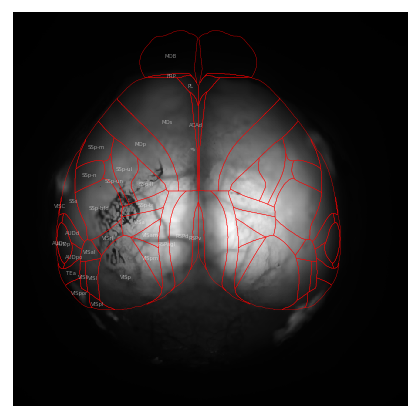

In [10]:
# %% plot ccf map on average frame

frames_ave = np.load(pjoin(path_wfield, 'frames_average.npy'))[0]
merge_frame_size = (512, 512)  # (width, height)
fig = plt.figure(figsize=(merge_frame_size[0] / 128, merge_frame_size[1] / 128), dpi=128)
plt.imshow(frames_ave, cmap='gray')
for i, r in ccf_regions_im.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')

plt.axis('off')
fig.set_facecolor('white')
plt.savefig(pjoin(path_out, 'ccf.png'), bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
path_ccf_stim = pjoin(path_out, experiment + '-avg-ccf-stim')
os.makedirs(path_ccf_stim, exist_ok=True)

for direction in ['up', 'down', 'left', 'right']:
    stim_file = pjoin(r'/home/lzx/data/WF_VC_liuzhaoxi/code/WF/others', 'moving-bar-' + direction + '.mp4')
    tif_avg = pjoin(path_out, direction + '-avg' + '.tif')
    avg_ccf_stim_file = pjoin(path_ccf_stim, os.path.basename(tif_avg)[:-4] + '-ccf-stim.mp4')
    merge_ccf_stim(avg_ccf_stim_file, tif_avg, ccf_regions_im, stim_file=stim_file, tif_fps=10, trial_rep=1,
                   vmin=-0.04, vmax=0.04, text=direction + '-avg ')
print('\nfinish all avg merging')


# for direction in ['up', 'down', 'left', 'right']:
#     stim_file = pjoin(r'/home/lzx/data/WF_VC_liuzhaoxi/code/WF/others', 'moving-bar-' + direction + '.mp4')
#     tif_avg = pjoin(path_out, 'tif', direction + '-avg-enhance' + '.tif')
#     avg_ccf_stim_file = pjoin(path_ccf_stim, os.path.basename(tif_avg)[:-4] + '-ccf-stim.mp4')
#     merge_ccf_stim(avg_ccf_stim_file, tif_avg, ccf_regions_im, stim_file=stim_file, tif_fps=10, trial_rep=1,
#                    vmin=200, vmax=25000, text=direction + '-avg ')
# print('\nfinish all avg merging')




In [ ]:
snr = cal_snr(tif_sort, axis1=4, axis2=2)
np.save(pjoin(path_out, 'snr.npy'), snr)
subplot_movie_heatmap(snr, 2, 2, direction_list, path_outfile=pjoin(path_out,f'{experiment}_{mouse}_moving-bar SNR'), title=f'{experiment}_{mouse}_moving-bar SNR', vmin=None, vmax=None,
                      cmap='hot', pixel_um=26,ccf_regions=ccf_regions_im)

# snr_filter = median_filter(snr,2)
# subplot_movie_heatmap(snr_filter, 2, 2, direction_list, path_outfile=pjoin(path_out,'moving-bar filter snr'), title='moving-bar filter snr', vmin=None, vmax=None,
#                       cmap='hot', pixel_um=26)

std=np.std(tif_sort, axis=(2,4))
np.save(pjoin(path_out, 'std.npy'), std)
subplot_movie_heatmap(std, 2, 2, direction_list, path_outfile=pjoin(path_out,f'{experiment}_{mouse}_moving-bar std'), title=f'{experiment}_{mouse}_moving-bar std', vmin=None, vmax=0.1,
                      cmap='hot', pixel_um=26,ccf_regions=ccf_regions_im)




In [41]:
def flat_mask(Uflat,xy):
    # index are in xy, like what np.where(mask) returns
    x = np.array(np.clip(xy[0],0,tif_height-1),dtype=int)
    y = np.array(np.clip(xy[1],0,tif_width-1),dtype=int)
    idx = np.ravel_multi_index((x,y),(tif_height,tif_width))
    t = Uflat[idx,:]
    return t

tif_sort_flat= tif_sort.reshape(tif_height*tif_width,-1)
all_area_timecourse=np.empty((33, tif_sort_flat.shape[-1]))
for area in range(1,34):
    all_area_timecourse[area-1] = flat_mask(tif_sort_flat,np.where(atlas_im == area)).mean(axis=0)



In [42]:
area_list = ['MOB','FRP','MOp','MOs','SSp-n','SSp-m','SSp-un','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

area_list1 = ['MOB','FRP','MOp','MOs','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSp-n','SSp-m','SSp-un','SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

area_idx = [area_list.index(area) for area in area_list1]

print(area_idx)

[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [43]:
from scipy.signal import correlate
import numpy as np

def compute_lag_correlation(matrix):
    """
    计算矩阵中每一行之间的归一化 lag correlation 和对应滞后。

    参数:
        matrix (numpy.ndarray): 输入二维矩阵，形状为 (n_rows, n_cols)

    返回:
        max_corr_matrix (numpy.ndarray): 最大绝对值相关性矩阵，形状为 (n_rows, n_rows)
        max_lag_matrix (numpy.ndarray): 最大相关性对应的滞后矩阵，形状为 (n_rows, n_rows)
    """
    n_rows = matrix.shape[0]
    max_corr_matrix = np.zeros((n_rows, n_rows))
    max_lag_matrix = np.zeros((n_rows, n_rows))

    for i in range(n_rows):
        for j in range(i, n_rows):  # 只计算上三角矩阵
            # 提取信号
            x = matrix[i]
            y = matrix[j]
            
            # 零均值处理
            x = x - np.mean(x)
            y = y - np.mean(y)
            
            # 计算 cross-correlation
            corr = correlate(x, y, mode='full', method='auto')
            
            # 归一化：除以 (std(x) * std(y) * len(x))
            normalization_factor = np.std(x) * np.std(y) * len(x)
            corr /= normalization_factor  # 将结果限制在 [-1, 1]
            
            # 找到最大绝对值相关性
            max_corr_idx = np.argmax(np.abs(corr))
            max_corr = corr[max_corr_idx]
            lag = max_corr_idx - (len(x) - 1)
            
            # 填入矩阵
            max_corr_matrix[i, j] = max_corr
            max_corr_matrix[j, i] = max_corr  # 对称性
            max_lag_matrix[i, j] = lag
            max_lag_matrix[j, i] = -lag  # 滞后是反对称的

    return max_corr_matrix, max_lag_matrix


# 调用函数
area_corr, area_lag = compute_lag_correlation(all_area_timecourse[area_idx])
np.save(pjoin(path_out,f'{mouse}_{experiment}_all area correlation.npy'), area_corr)
np.save(pjoin(path_out,f'{mouse}_{experiment}_all area correlation lag.npy'), area_lag)

In [32]:
def plot_heatmap(data, xlabel=None, ylabel=None, xtitle=None, ytitle=None, cmap='coolwarm', vmin=None, vmax=None, title=None, outfile=None, dpi=300, annot=True):
    import seaborn as sns
    import matplotlib.pyplot as plt

    if vmin == None:
        vmin = data.min()
    if vmax == None:
        vmax = data.max()

    fig, ax = plt.subplots(figsize=(data.shape[1], data.shape[0]))
    fig.set_facecolor('white')
    # 使用seaborn的heatmap函数来绘制热图
    sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, annot=annot, fmt=".3f", annot_kws={"size": 12, "color": 'black'},
                ax=ax, cbar=True, square=True, linewidths=0, cbar_kws={'fraction': 0.04, 'pad': 0.03})
    cbar = ax.collections[0].colorbar 
    cbar.ax.tick_params(labelsize=15) # 设置colorbar刻度标签的字号 
    
    if xtitle is not None:
        ax.set_xlabel(xtitle, fontsize=15)
    if xlabel is not None:
        ax.set_xticklabels(xlabel, rotation=45, ha='right', fontsize=15)
    if ytitle is not None:
        ax.set_ylabel(ytitle, fontsize=15)
    if ylabel is not None:
        ax.set_yticklabels(ylabel, rotation=0, fontsize=15)
    plt.gca().invert_yaxis()  # 倒置y轴

    if title:
        ax.set_title(title, fontsize=20)
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', dpi=dpi)

    plt.show()

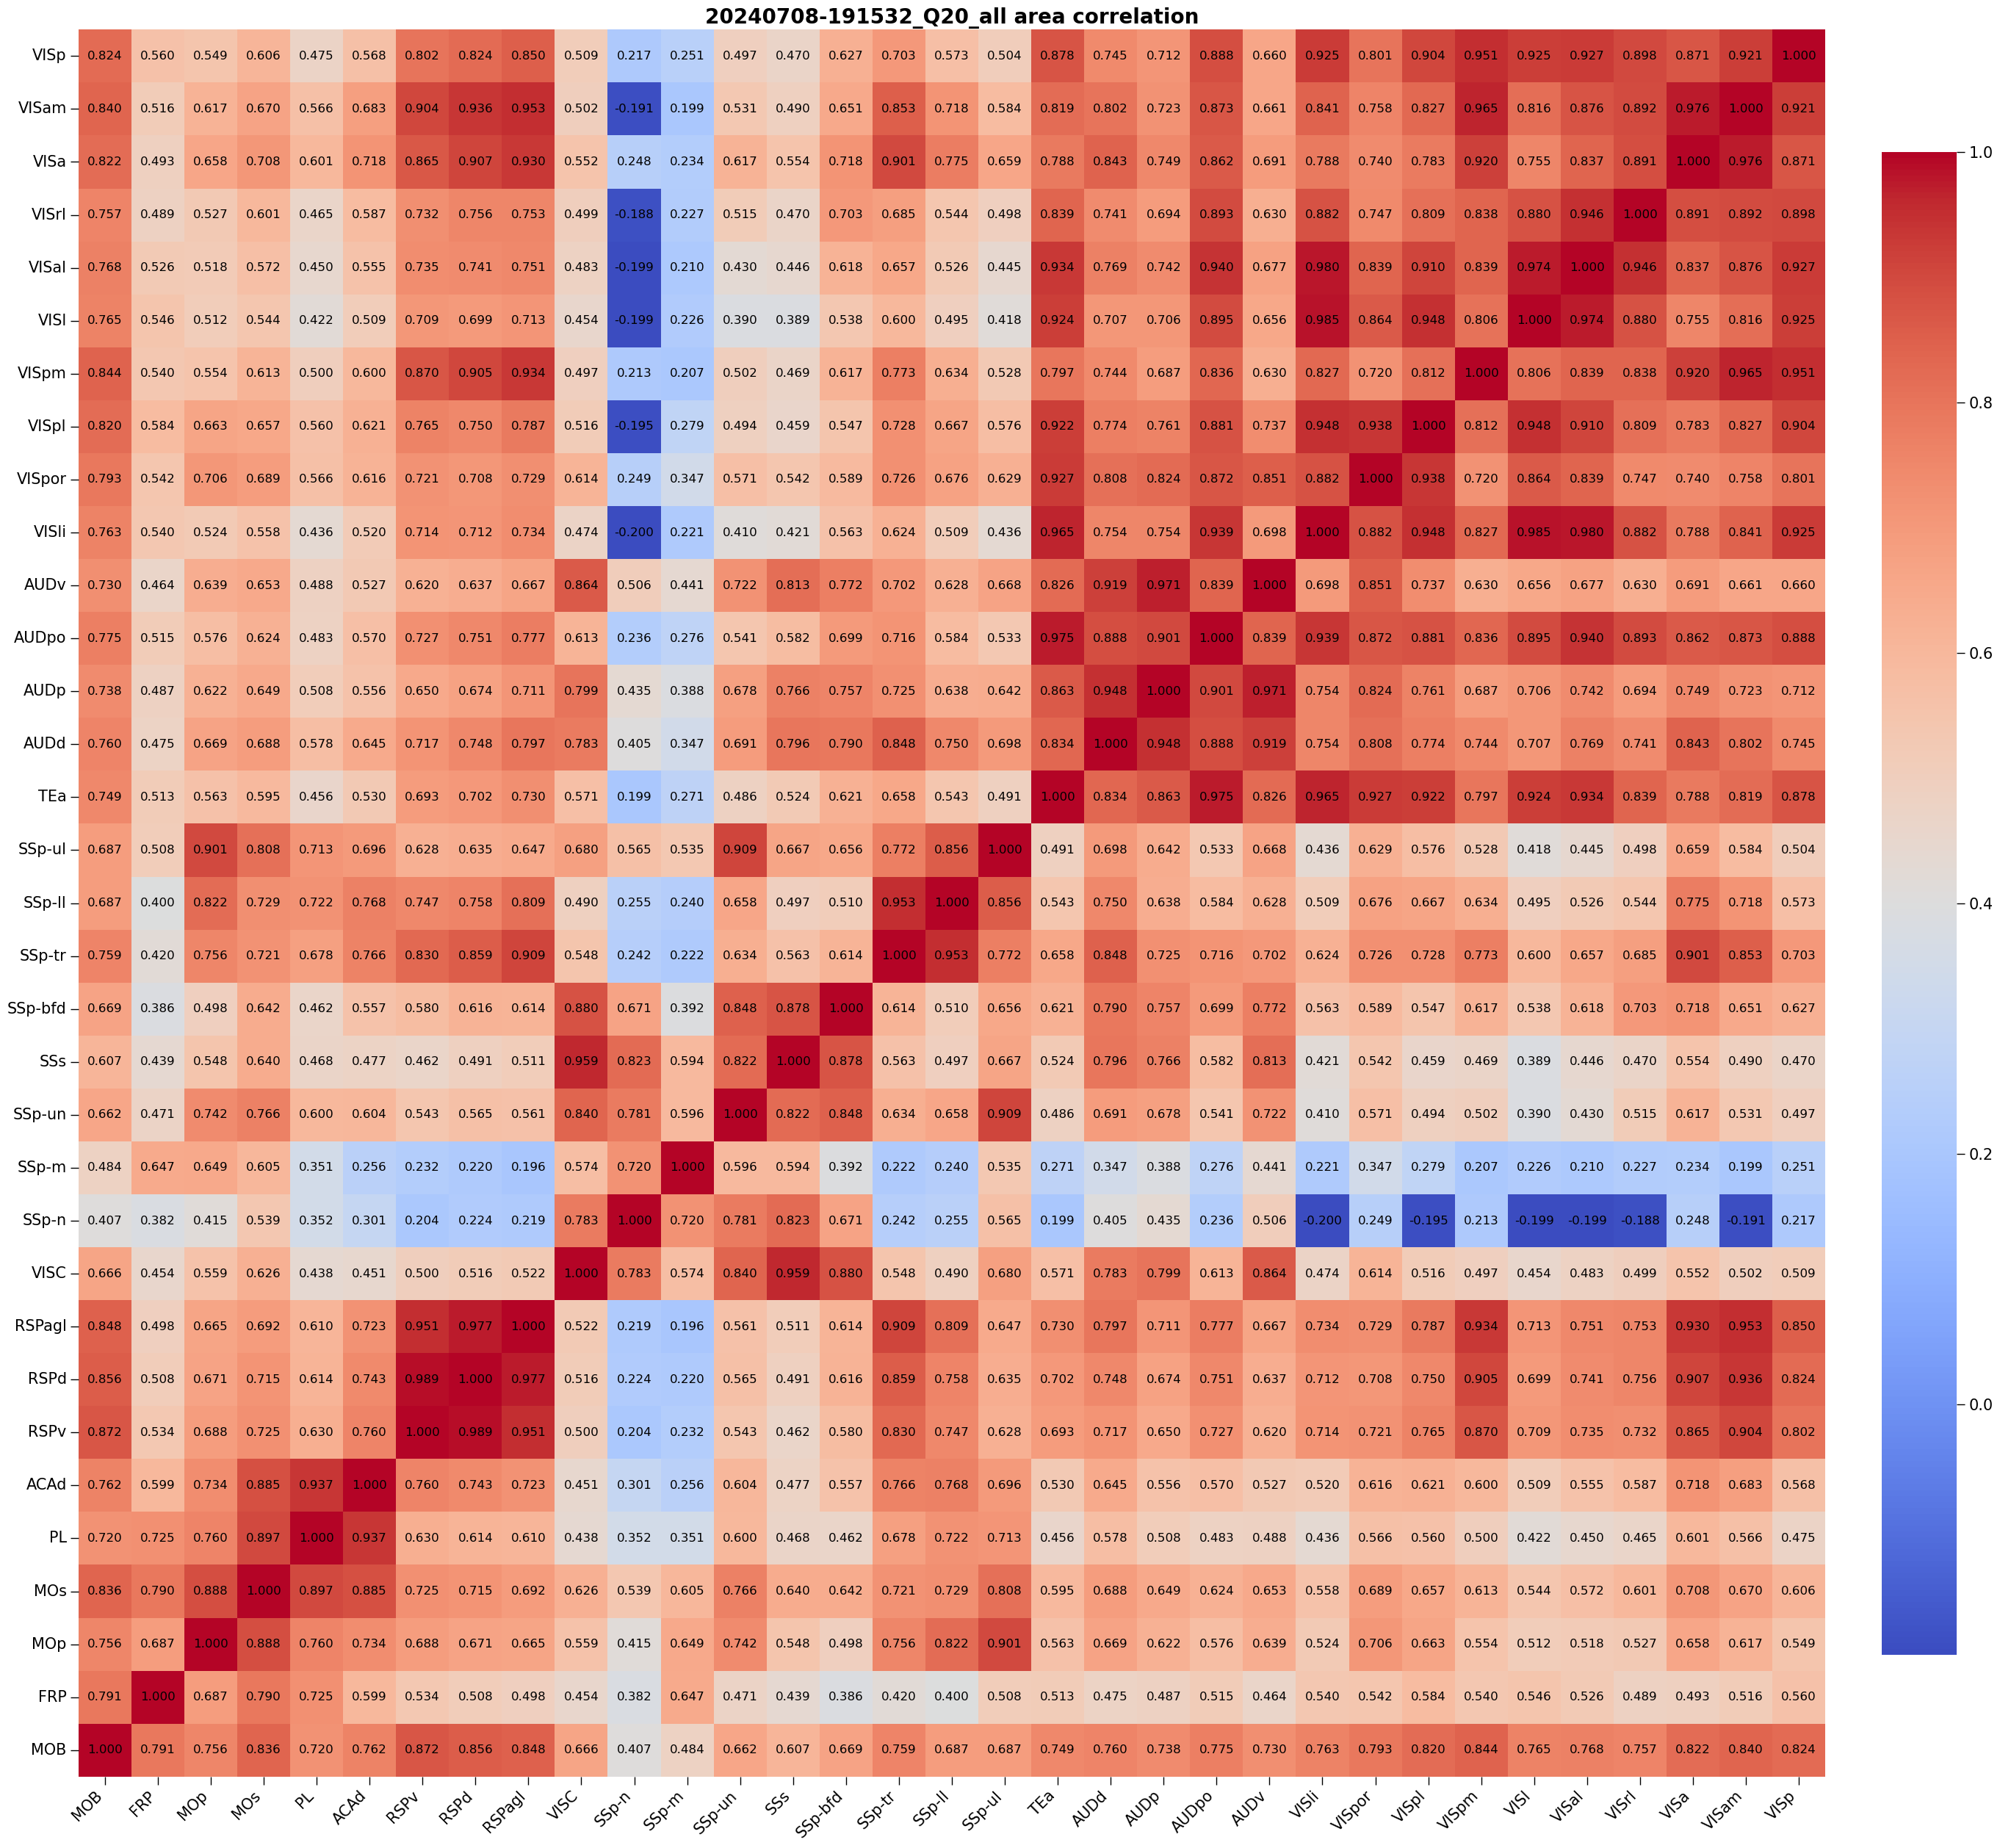

In [33]:
plot_heatmap(area_corr, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None, title=f'{experiment}_{mouse}_all area correlation', 
             outfile=pjoin(path_out,f'{mouse}_{experiment}_all area correlation.png'), dpi=300, annot=True)

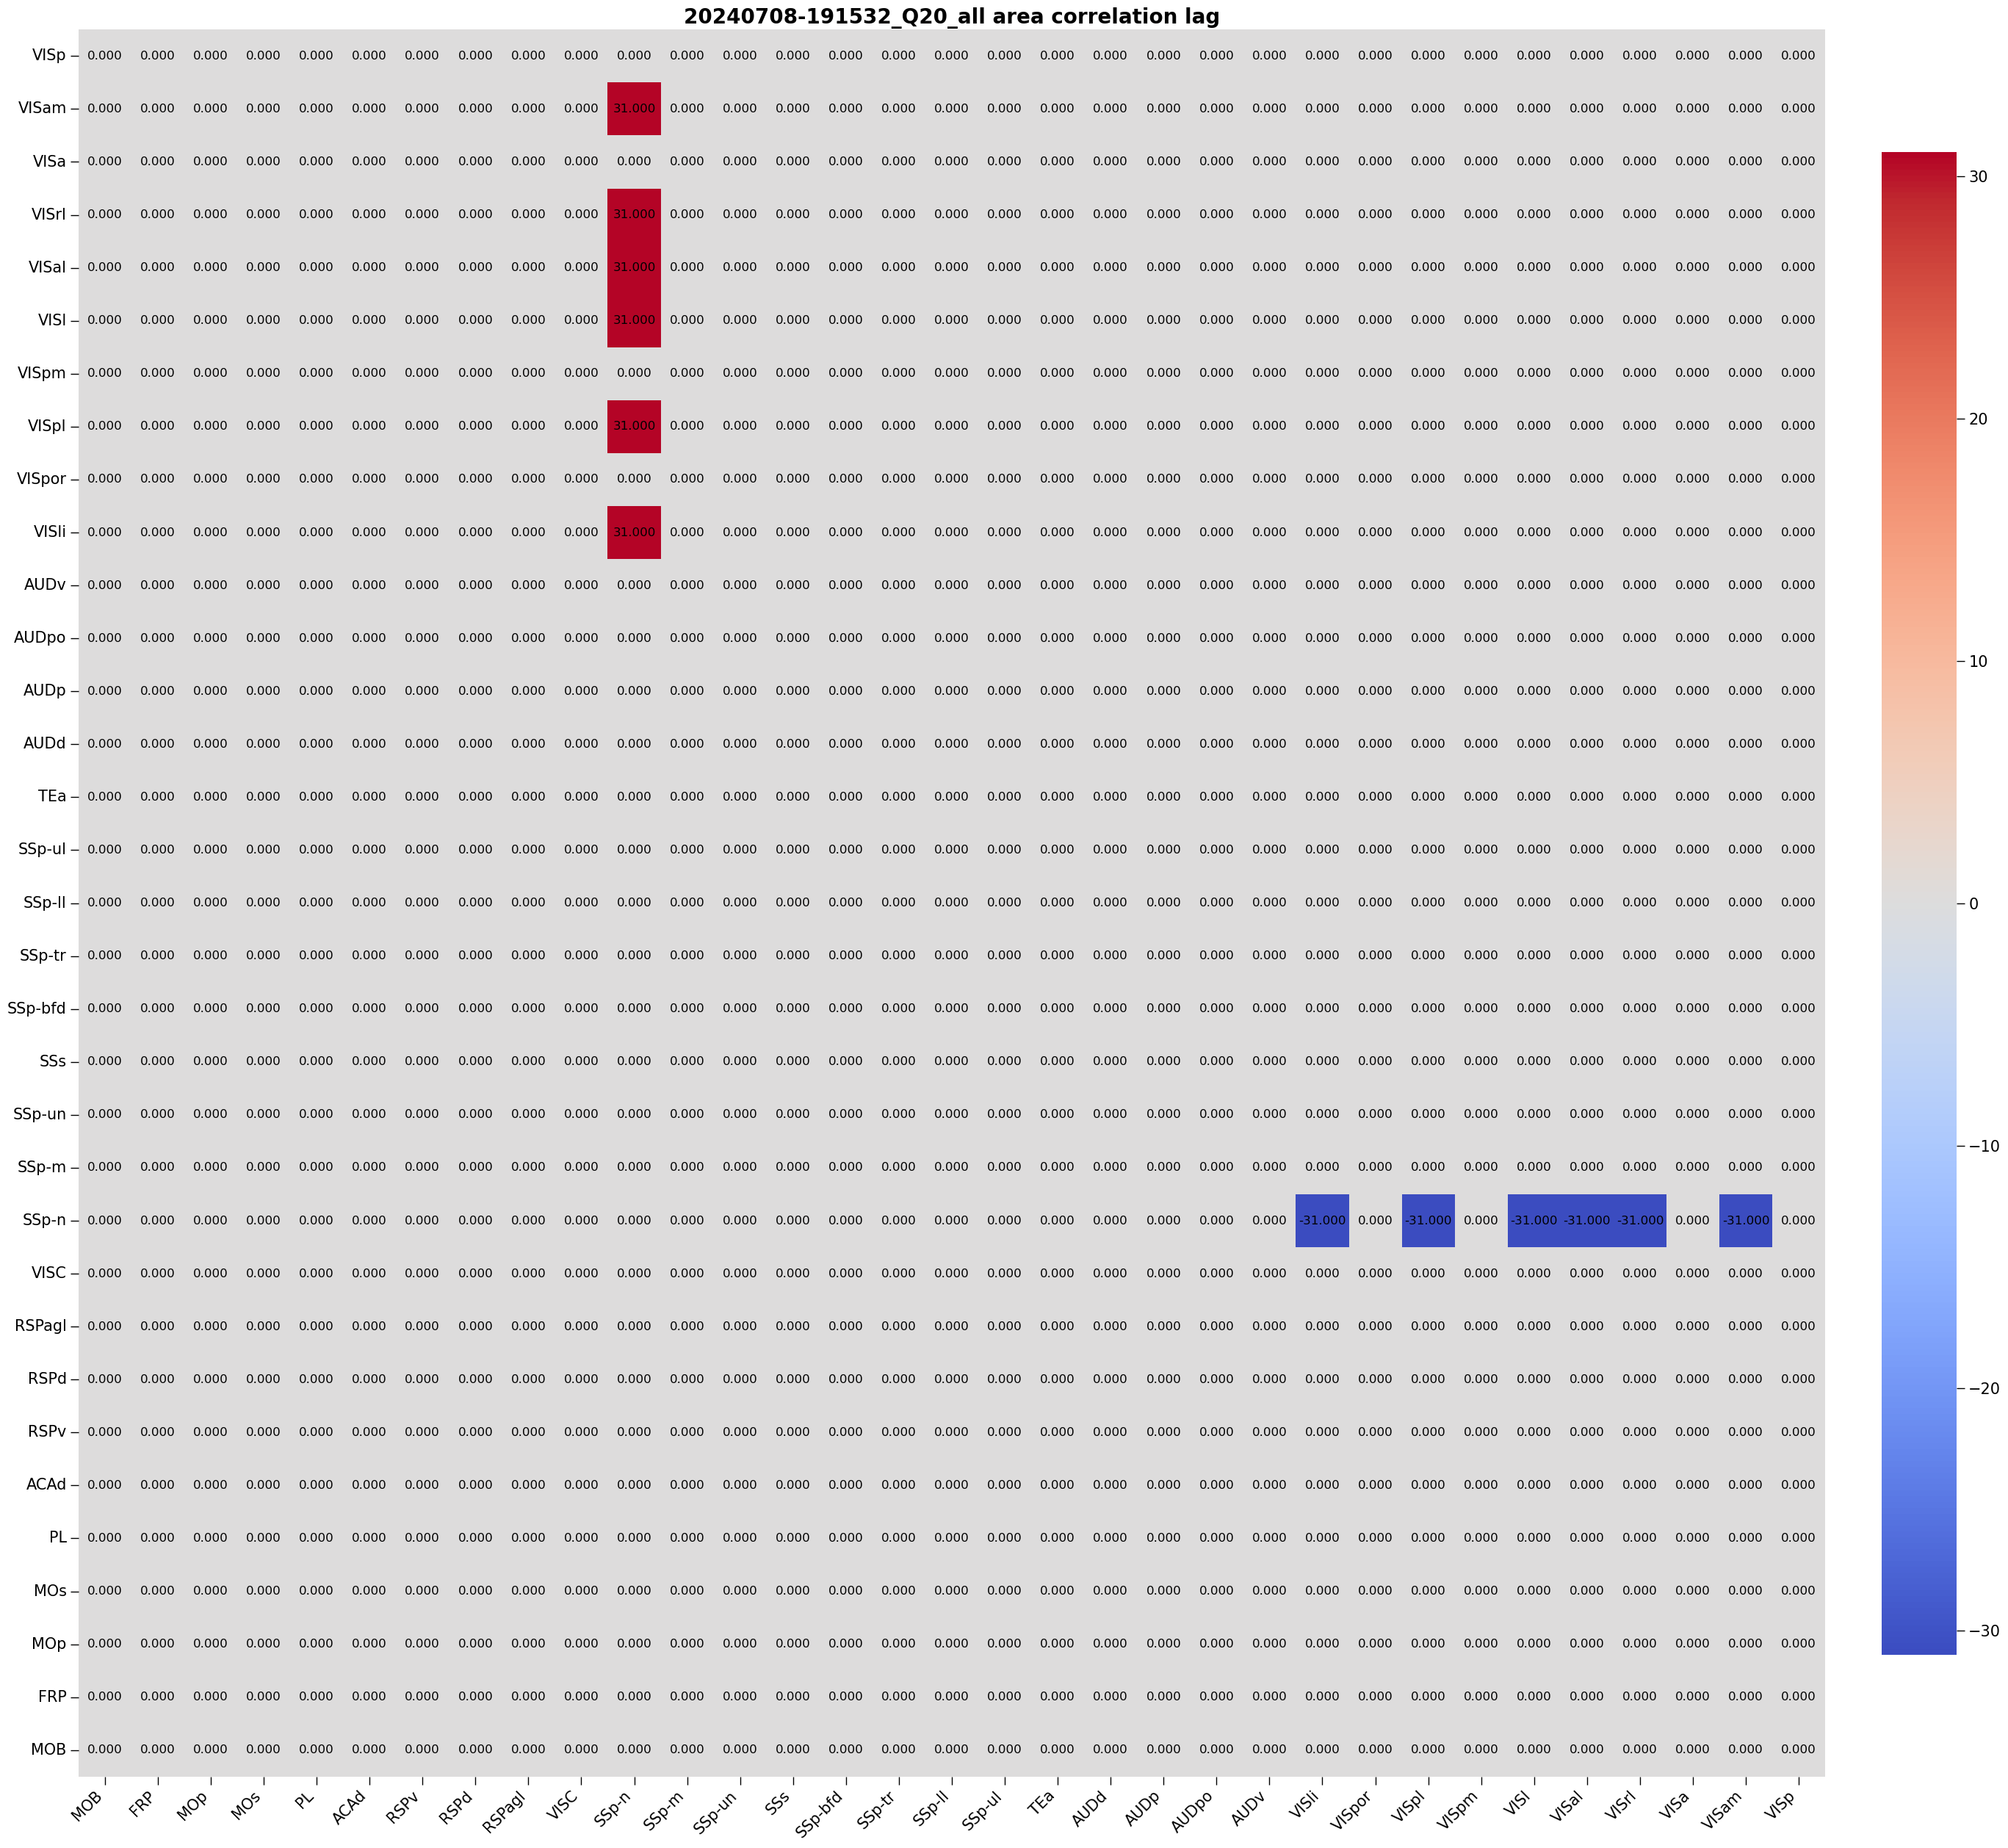

In [34]:
plot_heatmap(area_lag, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None, title=f'{experiment}_{mouse}_all area correlation lag', 
             outfile=pjoin(path_out,f'{mouse}_{experiment}_all area correlation lag.png'), dpi=300, annot=True)

## spatial ICA

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cupy as cp

cp._default_memory_pool.free_all_blocks()

In [11]:
# set ICA parameter

ICA_methods = 'jade'
n_IC = 20


In [15]:
tif_sort_flat = tif_sort.reshape(tif_height*tif_width,-1)
X = cp.asarray(tif_sort_flat.T)

print('ICA dim:', X.shape)

ICA dim: (2120, 262144)


In [47]:
%%time
if ICA_methods == 'jade':
    demix_matrix = jadeR_cupy(X, m=n_IC, verbose=True)
    IC = demix_matrix @ X
    IC_array = cp.asnumpy(IC).reshape(n_IC, *U.shape[:-1])
    mix_matrix = cp.asnumpy(cp.linalg.pinv(demix_matrix))
    
    del X, demix_matrix, IC
    cp._default_memory_pool.free_all_blocks()
    
elif ICA_methods == 'fast':
    from sklearn.decomposition import FastICA
    tif_corr_bin2 = tif_corr.reshape(tif_corr.shape[0], tif_corr.shape[1]//2, 2, tif_corr.shape[2]//2, 2).mean(axis=(2, 4))
    X_bin2 = tif_corr_bin2.reshape(tif_corr.shape[0], -1)
    fastica = FastICA(n_components=n_IC, whiten="arbitrary-variance")
    IC = fastica.fit_transform(X_bin2.T).T  
    mix_matrix = fastica.mixing_ 
    IC_array_bin2 = np.asarray(IC).reshape(n_IC, *tif_corr_bin2.shape[1:])
    IC_array = np.kron(IC_array_bin2, np.ones((1, 2, 2)))

mix_matrix_sort = mix_matrix.T.reshape(n_IC, *tif_sort.shape[2:])
np.save(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}.npy'), IC_array)
np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_mix_matrix_sort.npy'), mix_matrix_sort)
print('save ICA matrix')
print('IC_array.shape', IC_array.shape)
print('mix_matrix_sort.shape: (n_IC, n_frame, n_dir, n_rep) ', mix_matrix_sort.shape)


save ICA matrix
IC_array.shape (20, 512, 512)
mix_matrix_sort.shape: (n_IC, n_frame, n_dir, n_rep)  (20, 53, 4, 10)
CPU times: user 2.88 ms, sys: 19.4 ms, total: 22.3 ms
Wall time: 34.4 ms


In [26]:
# set IC threshold, adjust ± sign

def zscore(matrix, axis=(1,2)):
    mean = np.mean(matrix, axis=axis)
    std = np.std(matrix, axis=axis)
    zscore_matrix = (matrix - mean[:,None,None]) / std[:,None,None]
    return zscore_matrix


IC_arrayz = zscore(IC_array)
IC_arrayz_cut = np.copy(IC_arrayz)

z_cut = 3
IC_arrayz_cut[np.abs(IC_arrayz_cut) < z_cut] = 0
# IC_arrayz_cut[np.abs(IC_arrayz_cut) >= z_cut] = 1
ic_sign = np.where(np.mean(IC_arrayz_cut, axis=(1,2)) < 0, -1, 1)
IC_arrayz_cut = ic_sign[:, None, None] * IC_arrayz_cut  # 确保IC方向为正
mix_matrix = ic_sign * mix_matrix

In [49]:
##find cluster

def find_cluster(binary_image,area):
    """

    binary_image: (size1,size2),is a 2D matrix that has already been binarized
    area: int, the minimum area of the cluster,50~100 is a good choice for me
    """
    from scipy.ndimage import label, find_objects
    labeled_array, cluster_num = label(binary_image)
    print(f'cluster_num: {cluster_num}')
    objects = find_objects(labeled_array)
    new_binary_image = np.zeros_like(binary_image)
    for i in range(1,cluster_num+1):
        cluster = (labeled_array == i)
        new_binary_image[cluster] = cluster.sum()>=area
    return new_binary_image


IC_arrayz_cut_cluster = np.zeros((n_IC, tif_height, tif_width))
for iIC in range(n_IC):
    IC_arrayz_cut_cluster[iIC]=find_cluster(IC_arrayz_cut[iIC],100)
np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster.npy'), IC_arrayz_cut_cluster)


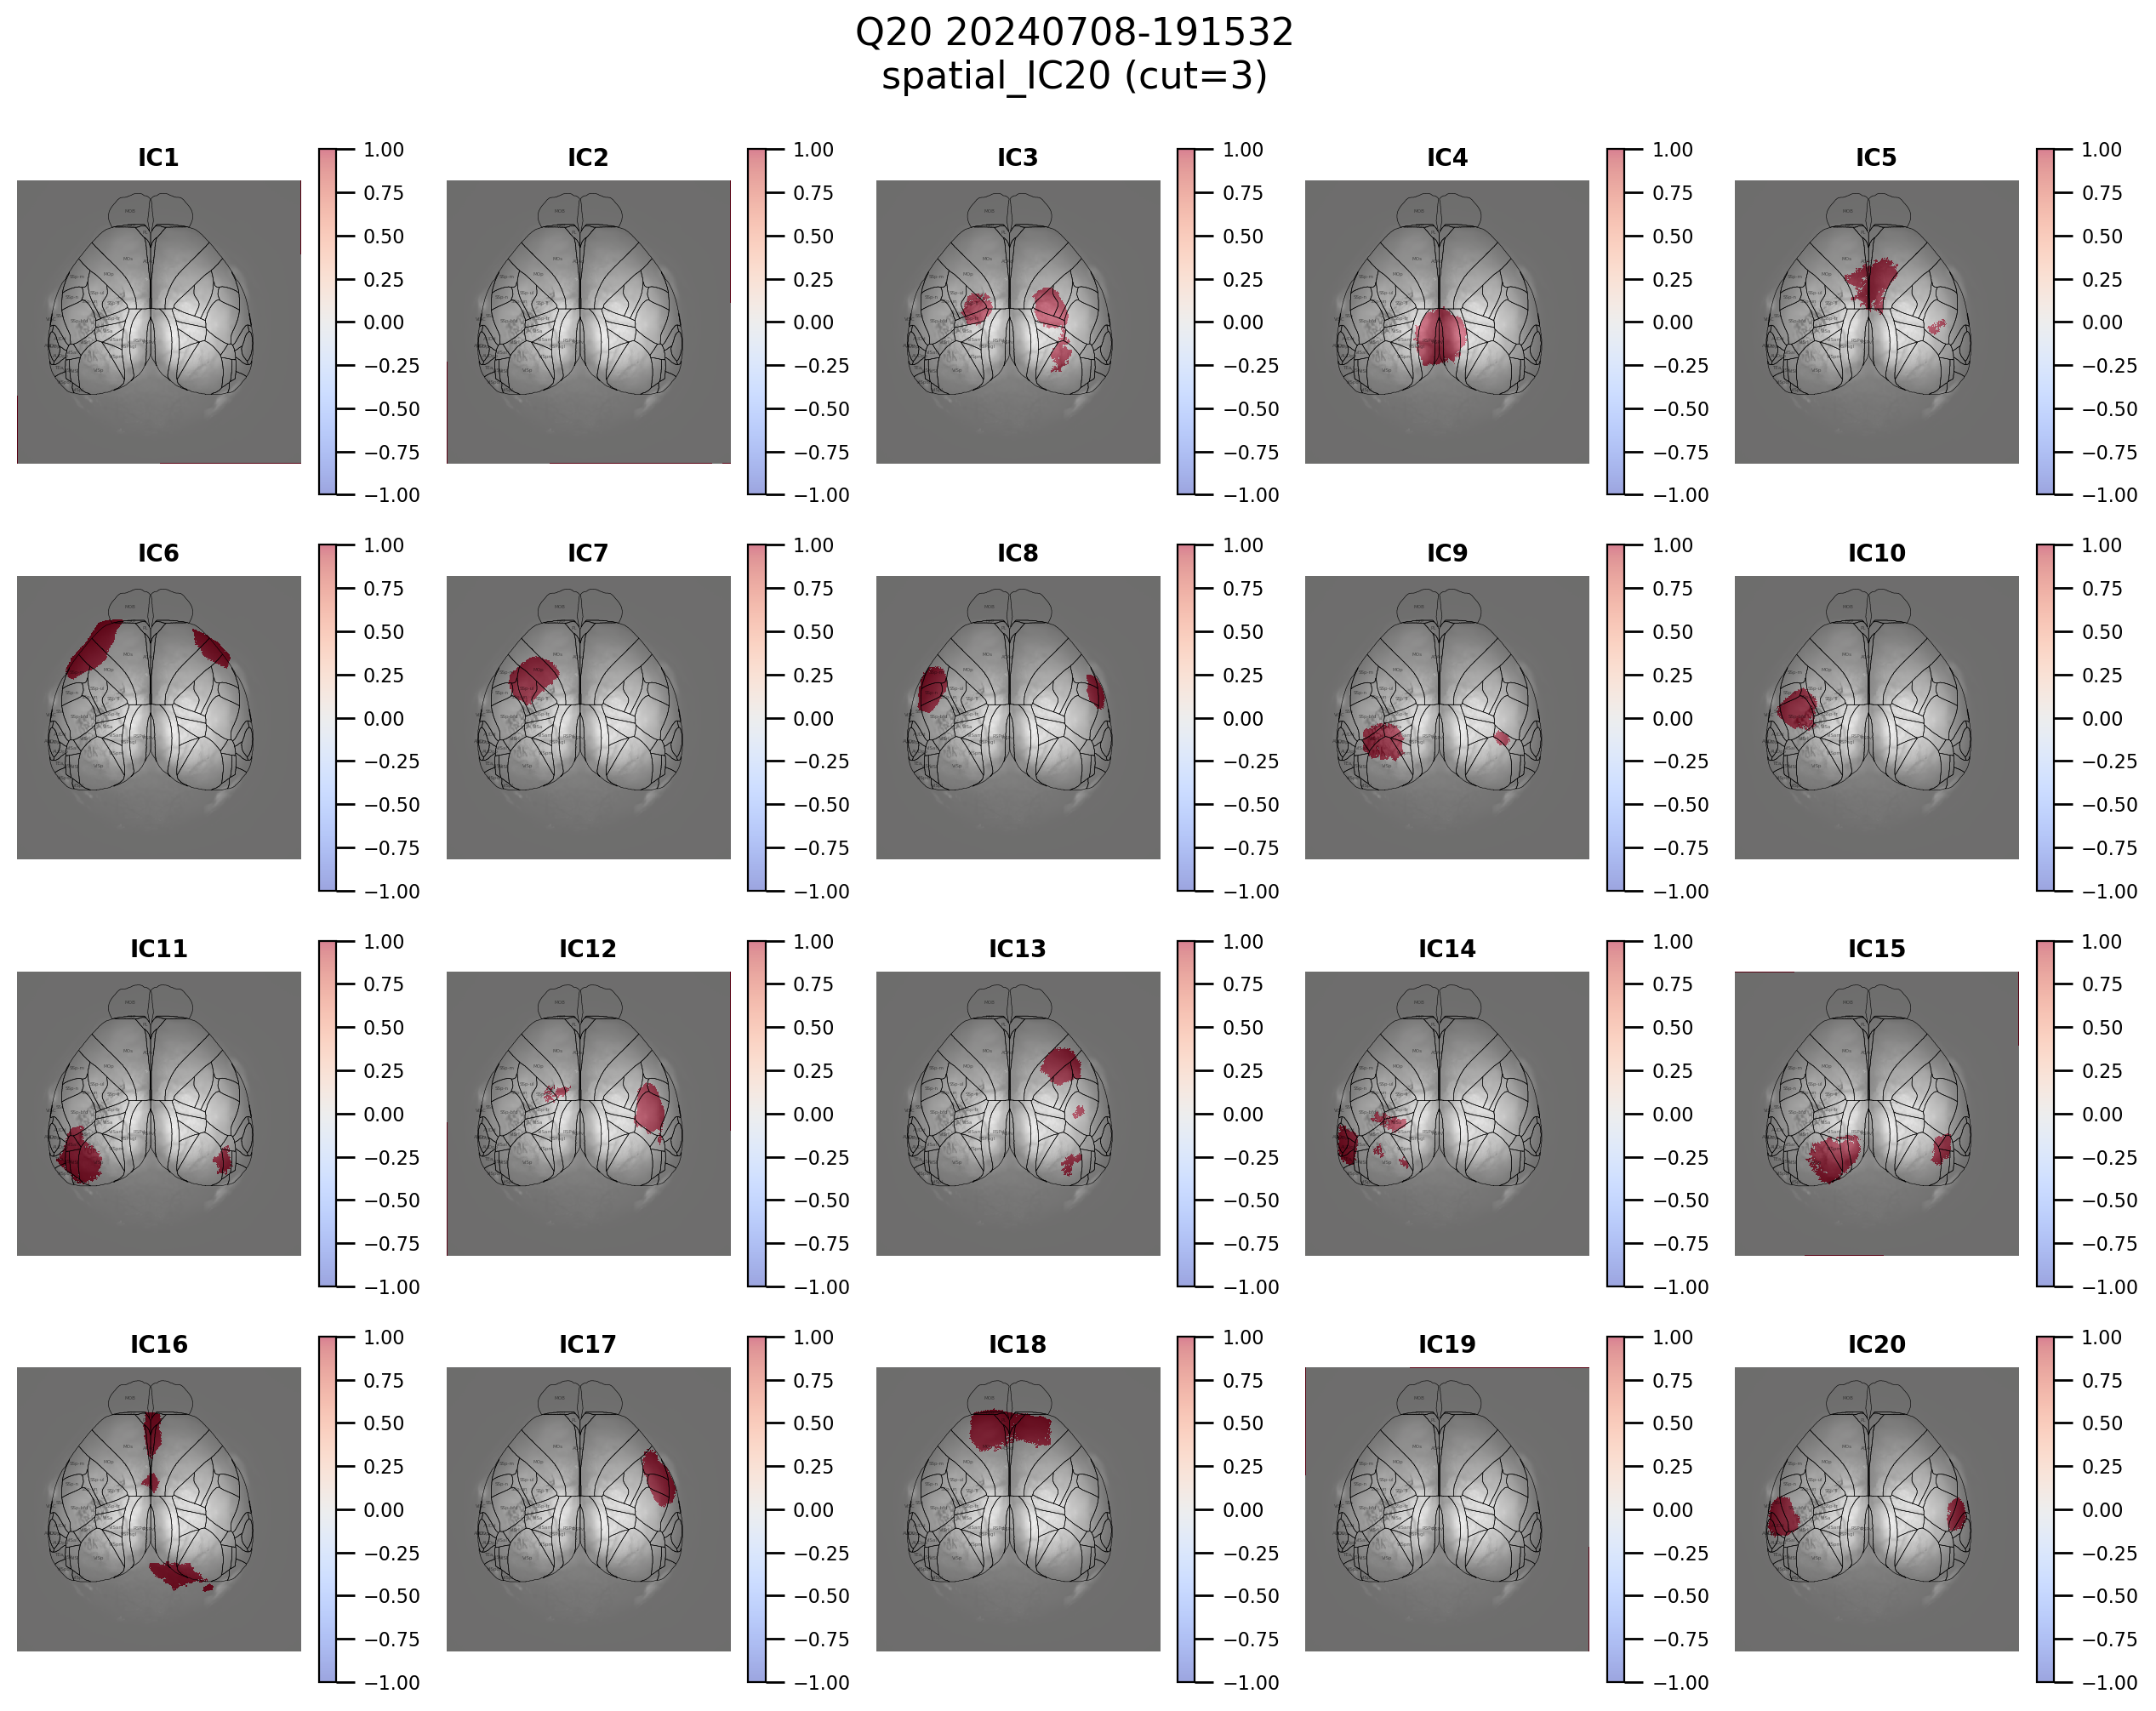

CPU times: user 12.7 s, sys: 226 ms, total: 12.9 s
Wall time: 12.9 s


In [58]:
%%time
# plot spatial IC

nrow = 4
ncol = 5
dpi = 200

fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
for irow in range(nrow):
    for icol in range(ncol):
        iIC = irow * ncol + icol
        ax[irow, icol].imshow(frames_ave, cmap='gray')
        img = ax[irow, icol].imshow(IC_arrayz_cut_cluster[iIC], cmap='coolwarm', clim=[-1,1], alpha=0.5)
        ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
        ax[irow, icol].axis('off')

        for idx, r in ccf_regions_im.iterrows():
            ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
            ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
            ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                alpha=0.5,
                                ha='center')
        fig.colorbar(img)
fig.set_facecolor('white')
fig.suptitle(f'{mouse} {experiment}\nspatial_IC{n_IC} (cut={z_cut})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}.png'), bbox_inches='tight', pad_inches=0)
plt.show()


In [55]:
from skimage.transform import warp

ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

IC_arrayz_cut_cluster_warped = warp(IC_arrayz_cut_cluster.transpose(1,2,0),lmarks['transform'],
                order = 1, mode='constant', cval = 0, clip=True, preserve_range=True, output_shape=(540, 600)).transpose(2,0,1)
np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster_warped.npy'), IC_arrayz_cut_cluster_warped)

frames_average_warped = warp(frames_average.transpose(1,2,0),lmarks['transform'],
                order = 1, mode='constant', cval = 0, clip=True, preserve_range=True, output_shape=(540, 600)).transpose(2,0,1)


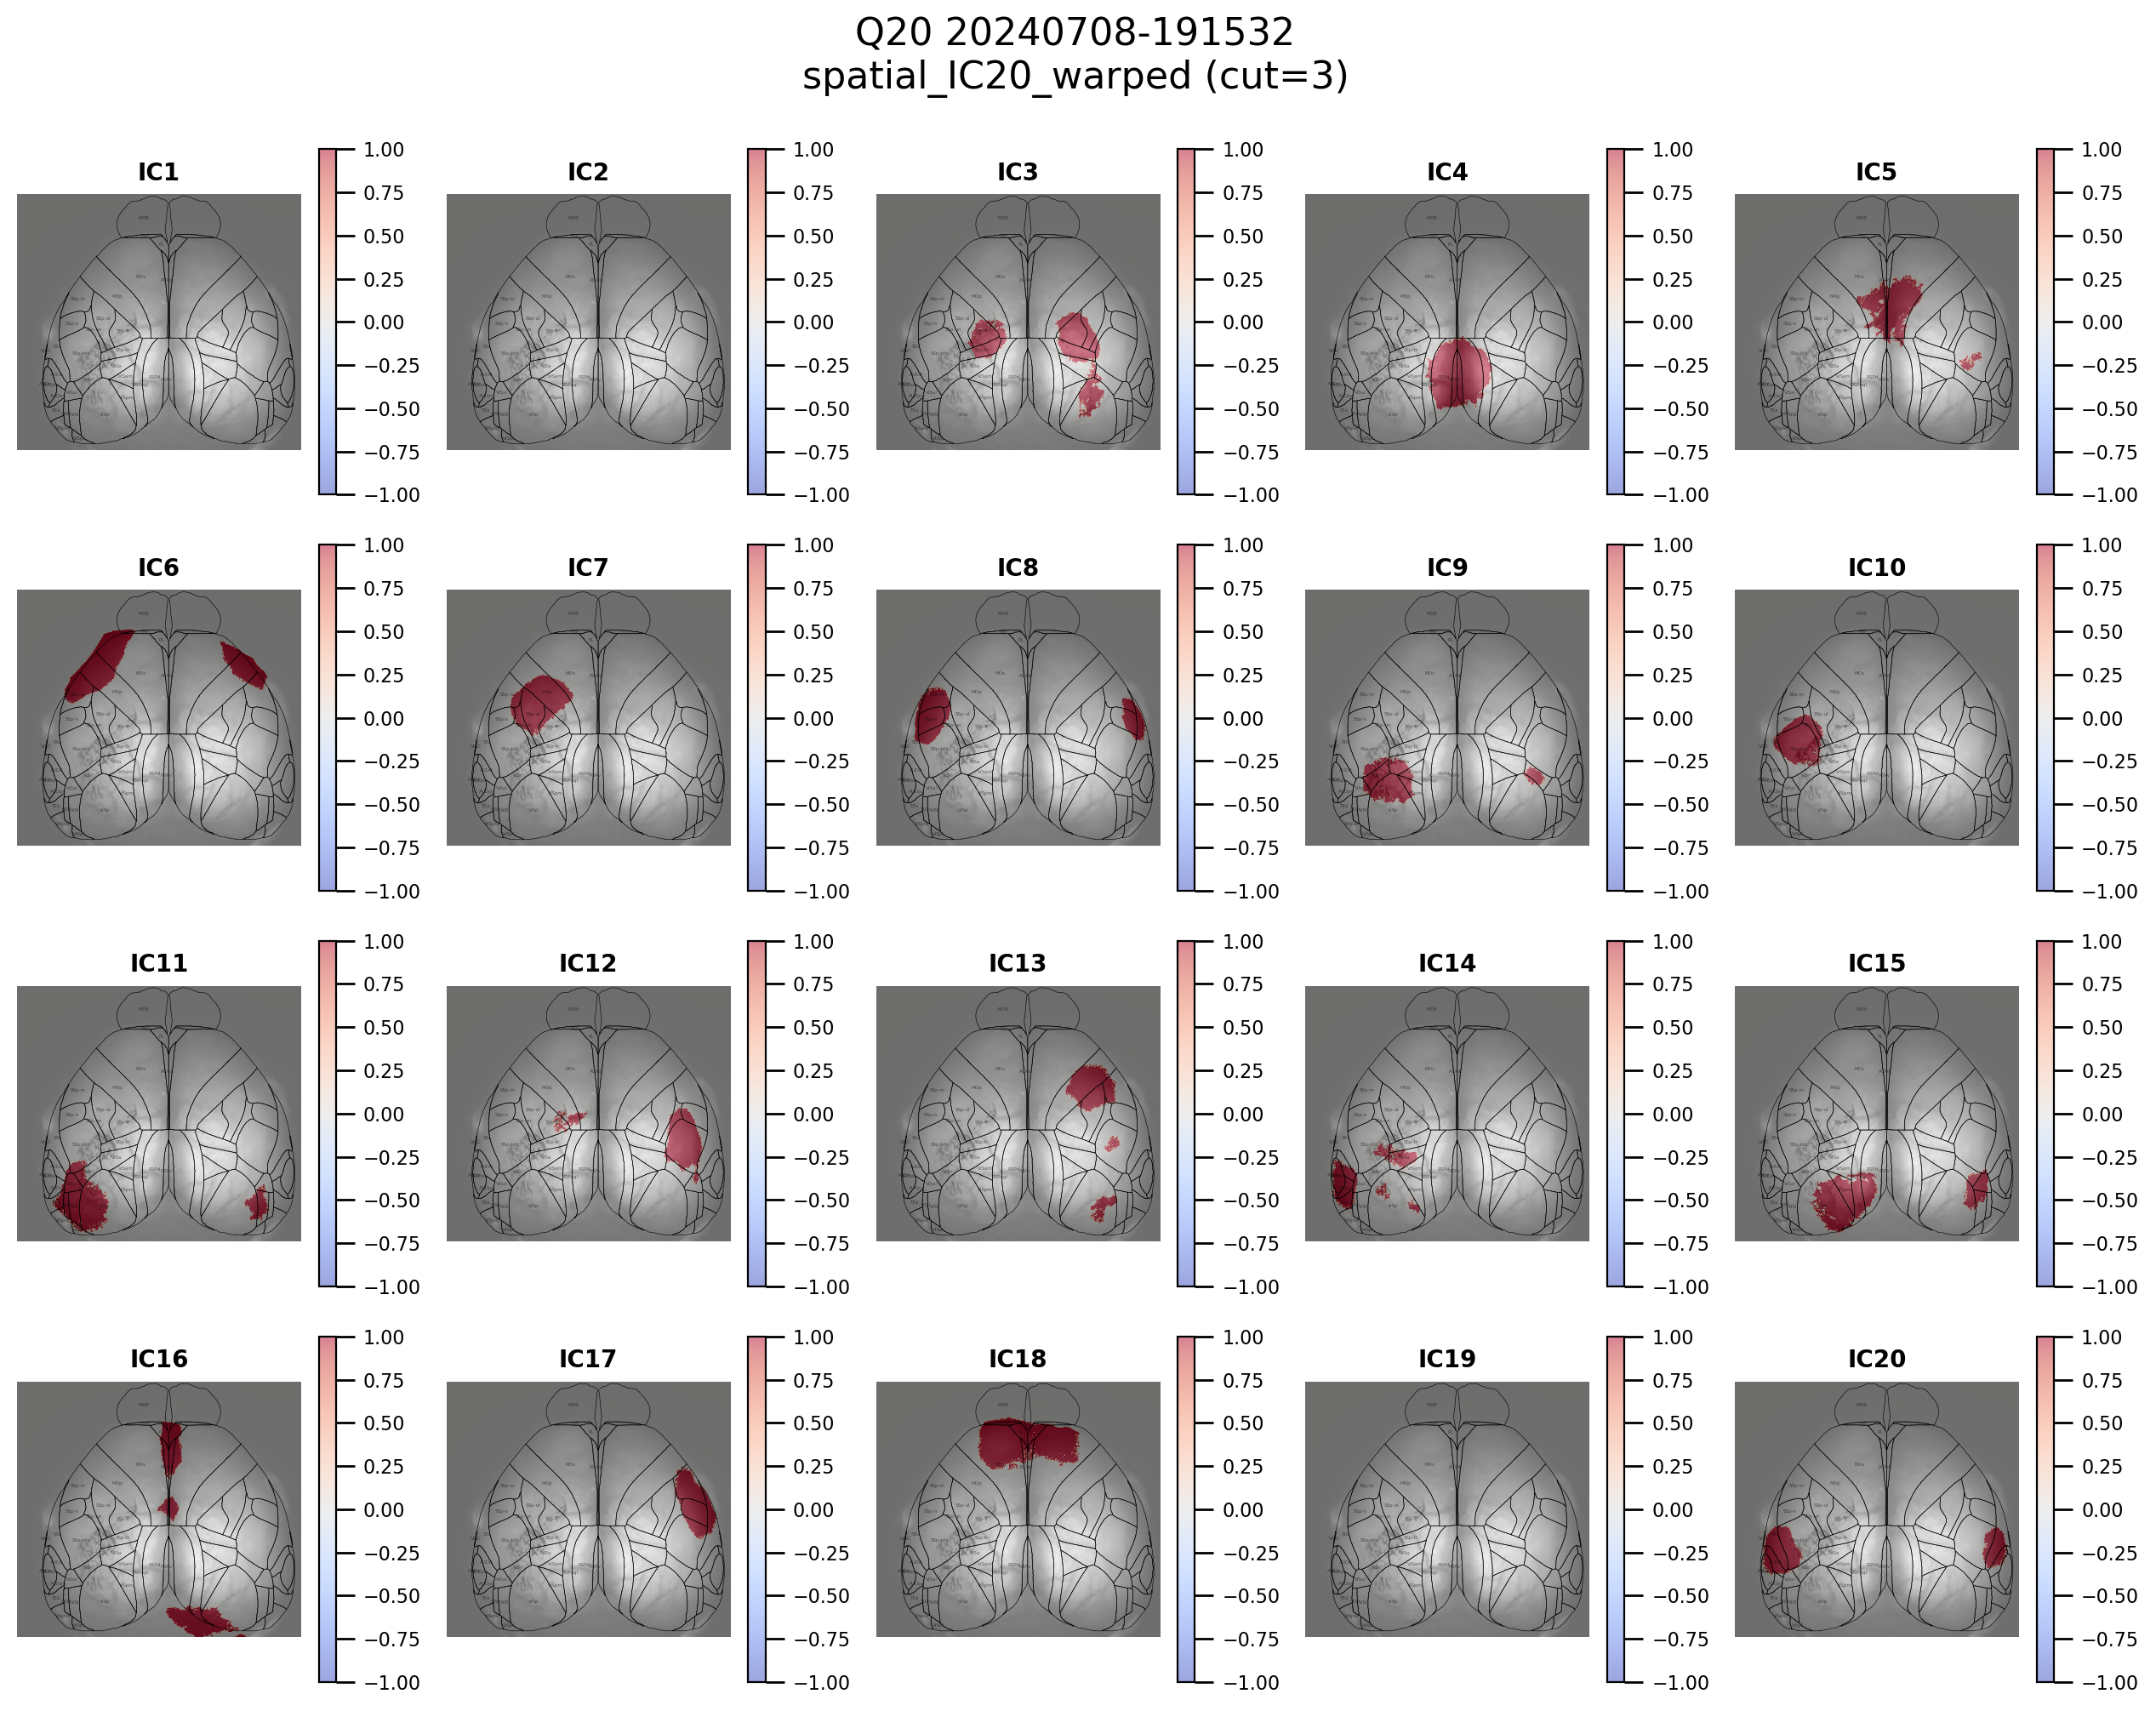

In [57]:
# plot warped spatial IC

nrow = 4
ncol = 5
dpi = 200

fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
for irow in range(nrow):
    for icol in range(ncol):
        iIC = irow * ncol + icol
        ax[irow, icol].imshow(frames_average_warped[0], cmap='gray')
        img = ax[irow, icol].imshow(IC_arrayz_cut_cluster_warped[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
        ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
        ax[irow, icol].axis('off')

        for idx, r in ccf_regions.iterrows():
            ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
            ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
            ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                alpha=0.5,
                                ha='center')
        fig.colorbar(img)
fig.set_facecolor('white')
fig.suptitle(f'{mouse} {experiment}\nspatial_IC{n_IC}_warped (cut={z_cut})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}_warped.png'), bbox_inches='tight', pad_inches=0)
plt.show()


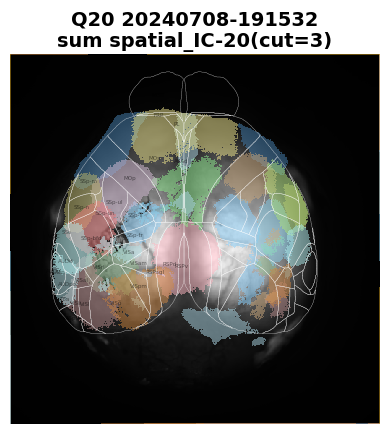

In [46]:
# plot superimposed spatial IC

from matplotlib.colors import ListedColormap

color_list = [
    "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8", 
    "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6", 
    "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD", 
    "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA", 
    "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700", 
    "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1", 
    "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1", 
    "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9", 
    "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
]


fig,ax = plt.subplots()
plt.imshow(frames_ave, cmap='gray')

# 逐个叠加IC，使用不同颜色
for i in range(n_IC):
    cmap = ListedColormap(['None', color_list[i]])
    plt.imshow(IC_arrayz_cut_cluster[i], cmap=cmap, interpolation='nearest', alpha=0.5)

for i, r in ccf_regions_im.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')

# plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
#                  borderWidth=1, isColor=True, plotName=True, fontSize=7)

plt.axis('off')
# plt.colorbar()
fig.set_facecolor('white')
plt.title(f'{mouse} {experiment}\nsum spatial_IC-{n_IC}(cut={z_cut})')
plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_sum spatial-IC-{n_IC}___colored.png'), bbox_inches='tight', pad_inches=0)
plt.show()

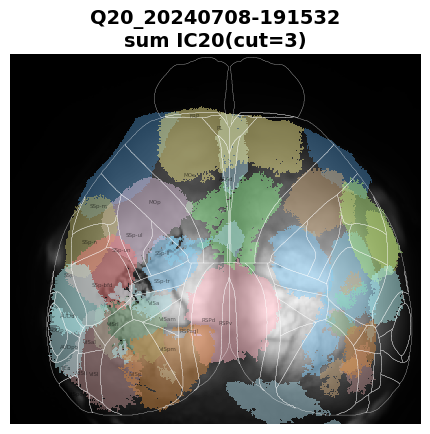

In [59]:
# plot warped superimposed spatial IC

from matplotlib.colors import ListedColormap

color_list = [
    "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8", 
    "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6", 
    "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD", 
    "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA", 
    "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700", 
    "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1", 
    "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1", 
    "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9", 
    "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
]


fig,ax = plt.subplots()
plt.imshow(frames_average_warped[0], cmap='gray')

# 逐个叠加IC，使用不同颜色
for i in range(n_IC):
    cmap = ListedColormap(['None', color_list[i]])
    plt.imshow(IC_arrayz_cut_cluster_warped[i], cmap=cmap, interpolation='nearest', alpha=0.5)

for i, r in ccf_regions.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')

# plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
#                  borderWidth=1, isColor=True, plotName=True, fontSize=7)

plt.axis('off')
# plt.colorbar()
fig.set_facecolor('white')
plt.title(f'{mouse}_{experiment}\nsum IC{n_IC}(cut={z_cut})')
plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_sum IC{n_IC}___colored_warped.png'), bbox_inches='tight', pad_inches=0)
plt.show()

In [31]:
# align timecourse


# mix_matrix.T: [n_IC, n_frame] 
# timecourse: [n_IC, n_frame, n_movie, n_rep]

# timecourse = sorting_4direct(mix_matrix.T, trialfile[:, 1], seq[:, 0], stim_len).astype('float32')
timecourse = mix_matrix.T.reshape(n_IC, *tif_sort.shape[2:])
print('timecourse.shape: (n_IC, n_frame, n_dir, n_rep) ', timecourse.shape)
# n_rep = timecourse.shape[-1]
# timecourse_mean = np.mean(timecourse, axis=3)


timecourse.shape: (n_IC, n_frame, n_dir, n_rep)  (20, 53, 4, 10)


timecourse_snr.shape (20, 4)


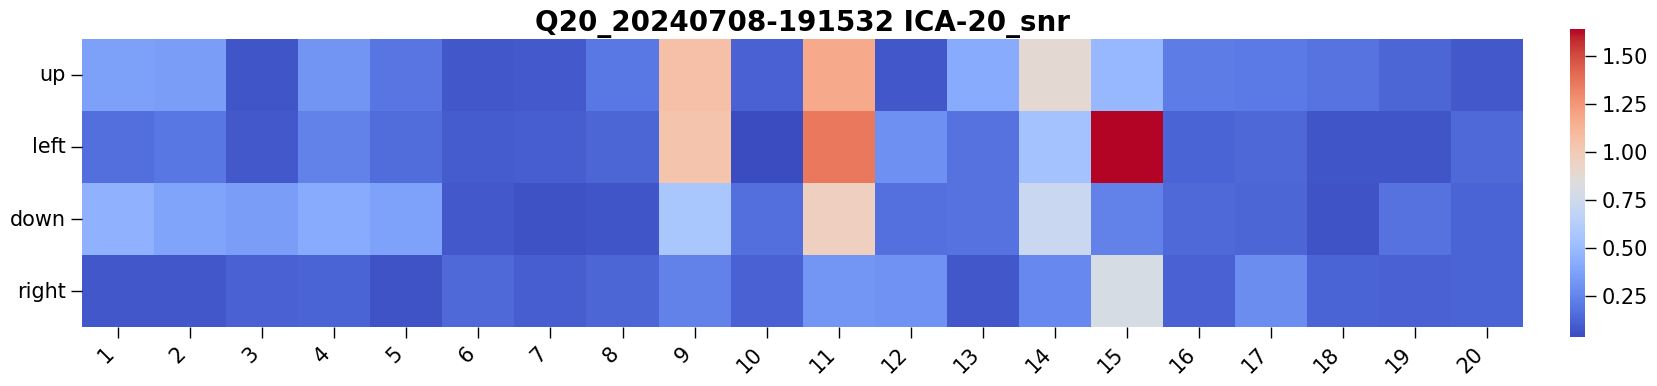

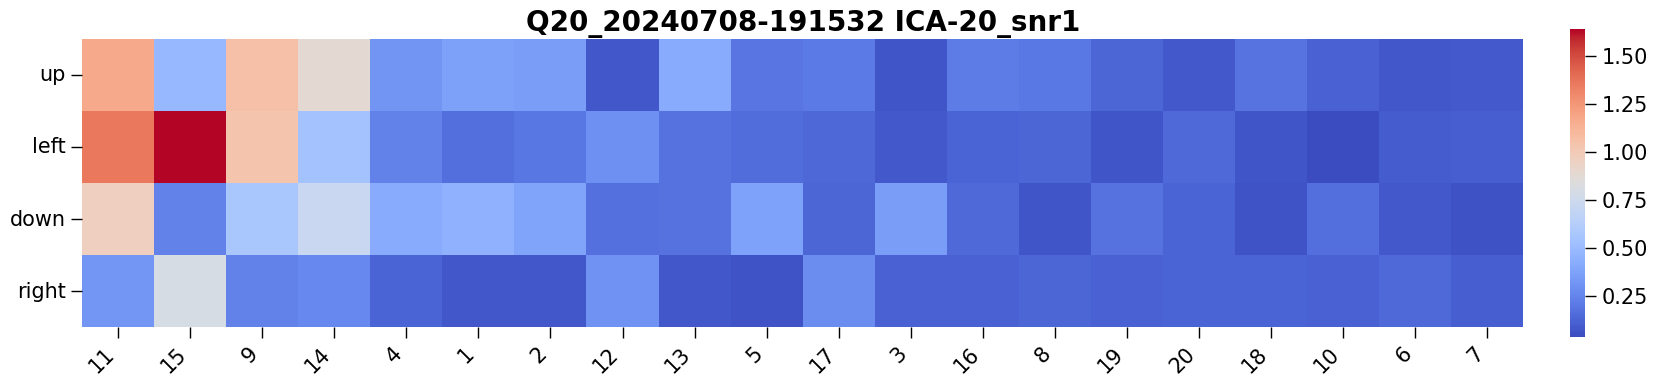

timecourse1.shape (10, 4, 53, 10)


In [34]:
# select top10 SNR ICs.

timecourse_snr = cal_snr(timecourse, axis1=3, axis2=1)
print('timecourse_snr.shape', timecourse_snr.shape)

IC_idx = np.argsort(np.mean(timecourse_snr, axis=1))[::-1]
timecourse_snr1=timecourse_snr[IC_idx]

plot_heatmap(timecourse_snr.T, xlabel=range(1,n_IC+1), ylabel=direction_list, cmap='coolwarm',
             title=f'{mouse}_{experiment} ICA-{n_IC}_snr', dpi=300,annot=False, 
             outfile=pjoin(path_out, f'{mouse}_{experiment} ICA-{n_IC}_snr.png'))
plot_heatmap(timecourse_snr1.T, xlabel=IC_idx+1, ylabel=direction_list, cmap='coolwarm',
             title=f'{mouse}_{experiment} ICA-{n_IC}_snr1', dpi=300,annot=False,
             outfile=pjoin(path_out, f'{mouse}_{experiment} ICA-{n_IC}_snr1.png'))

timecourse1=timecourse[IC_idx[:10]].transpose(0,2,1,3)
print('timecourse1.shape', timecourse1.shape)

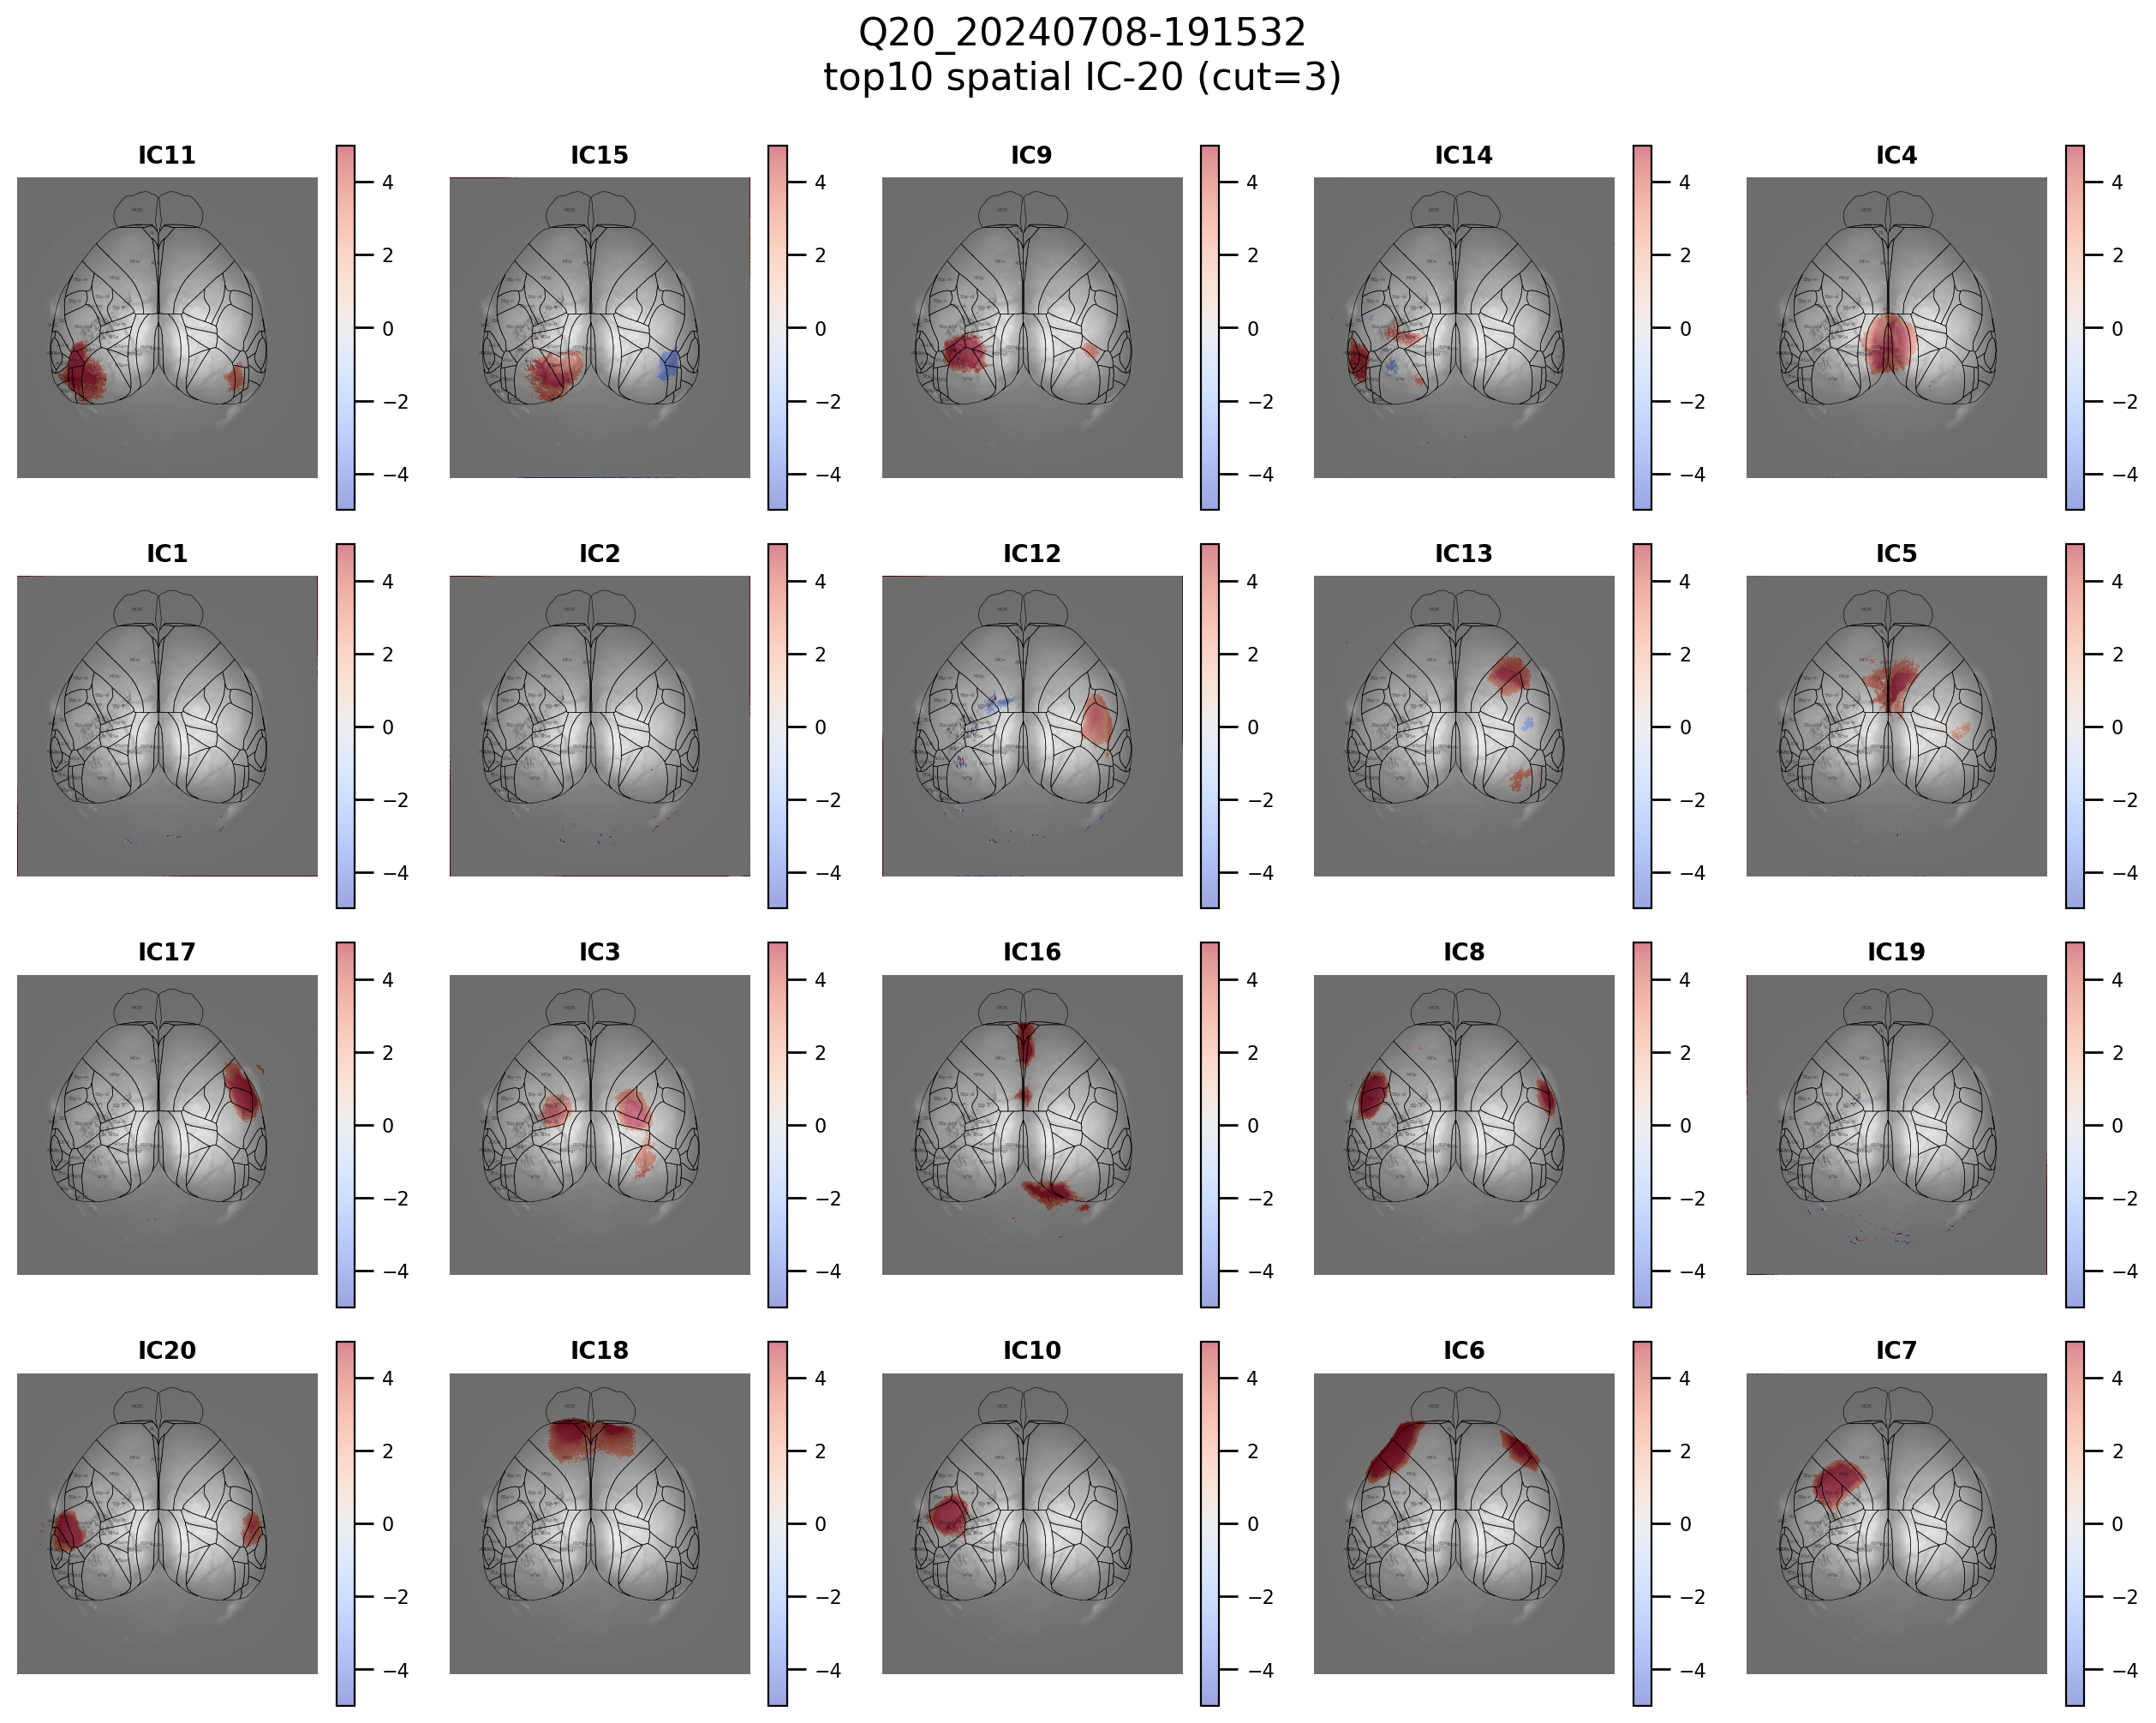

In [35]:
# plot top10 spatial IC

IC_arrayz_cut1=IC_arrayz_cut[IC_idx]

nrow = 4
ncol = 5
dpi = 200

fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
for irow in range(nrow):
    for icol in range(ncol):
        iIC = irow * ncol + icol
        ax[irow, icol].imshow(frames_ave, cmap='gray')
        img = ax[irow, icol].imshow(IC_arrayz_cut1[iIC], cmap='coolwarm', clim=[-5,5], alpha=0.5)
        ax[irow, icol].set_title('IC{}'.format(IC_idx[iIC] + 1), fontsize=10)
        ax[irow, icol].axis('off')

        for idx, r in ccf_regions_im.iterrows():
            ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
            ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
            ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                alpha=0.5,
                                ha='center')
        fig.colorbar(img)
fig.set_facecolor('white')
fig.suptitle(f'{mouse}_{experiment}\ntop10 spatial IC-{n_IC} (cut={z_cut})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(pjoin(path_out, f'{mouse}_{experiment} top10 spatial IC-{n_IC}.png'), bbox_inches='tight', pad_inches=0)
plt.show()


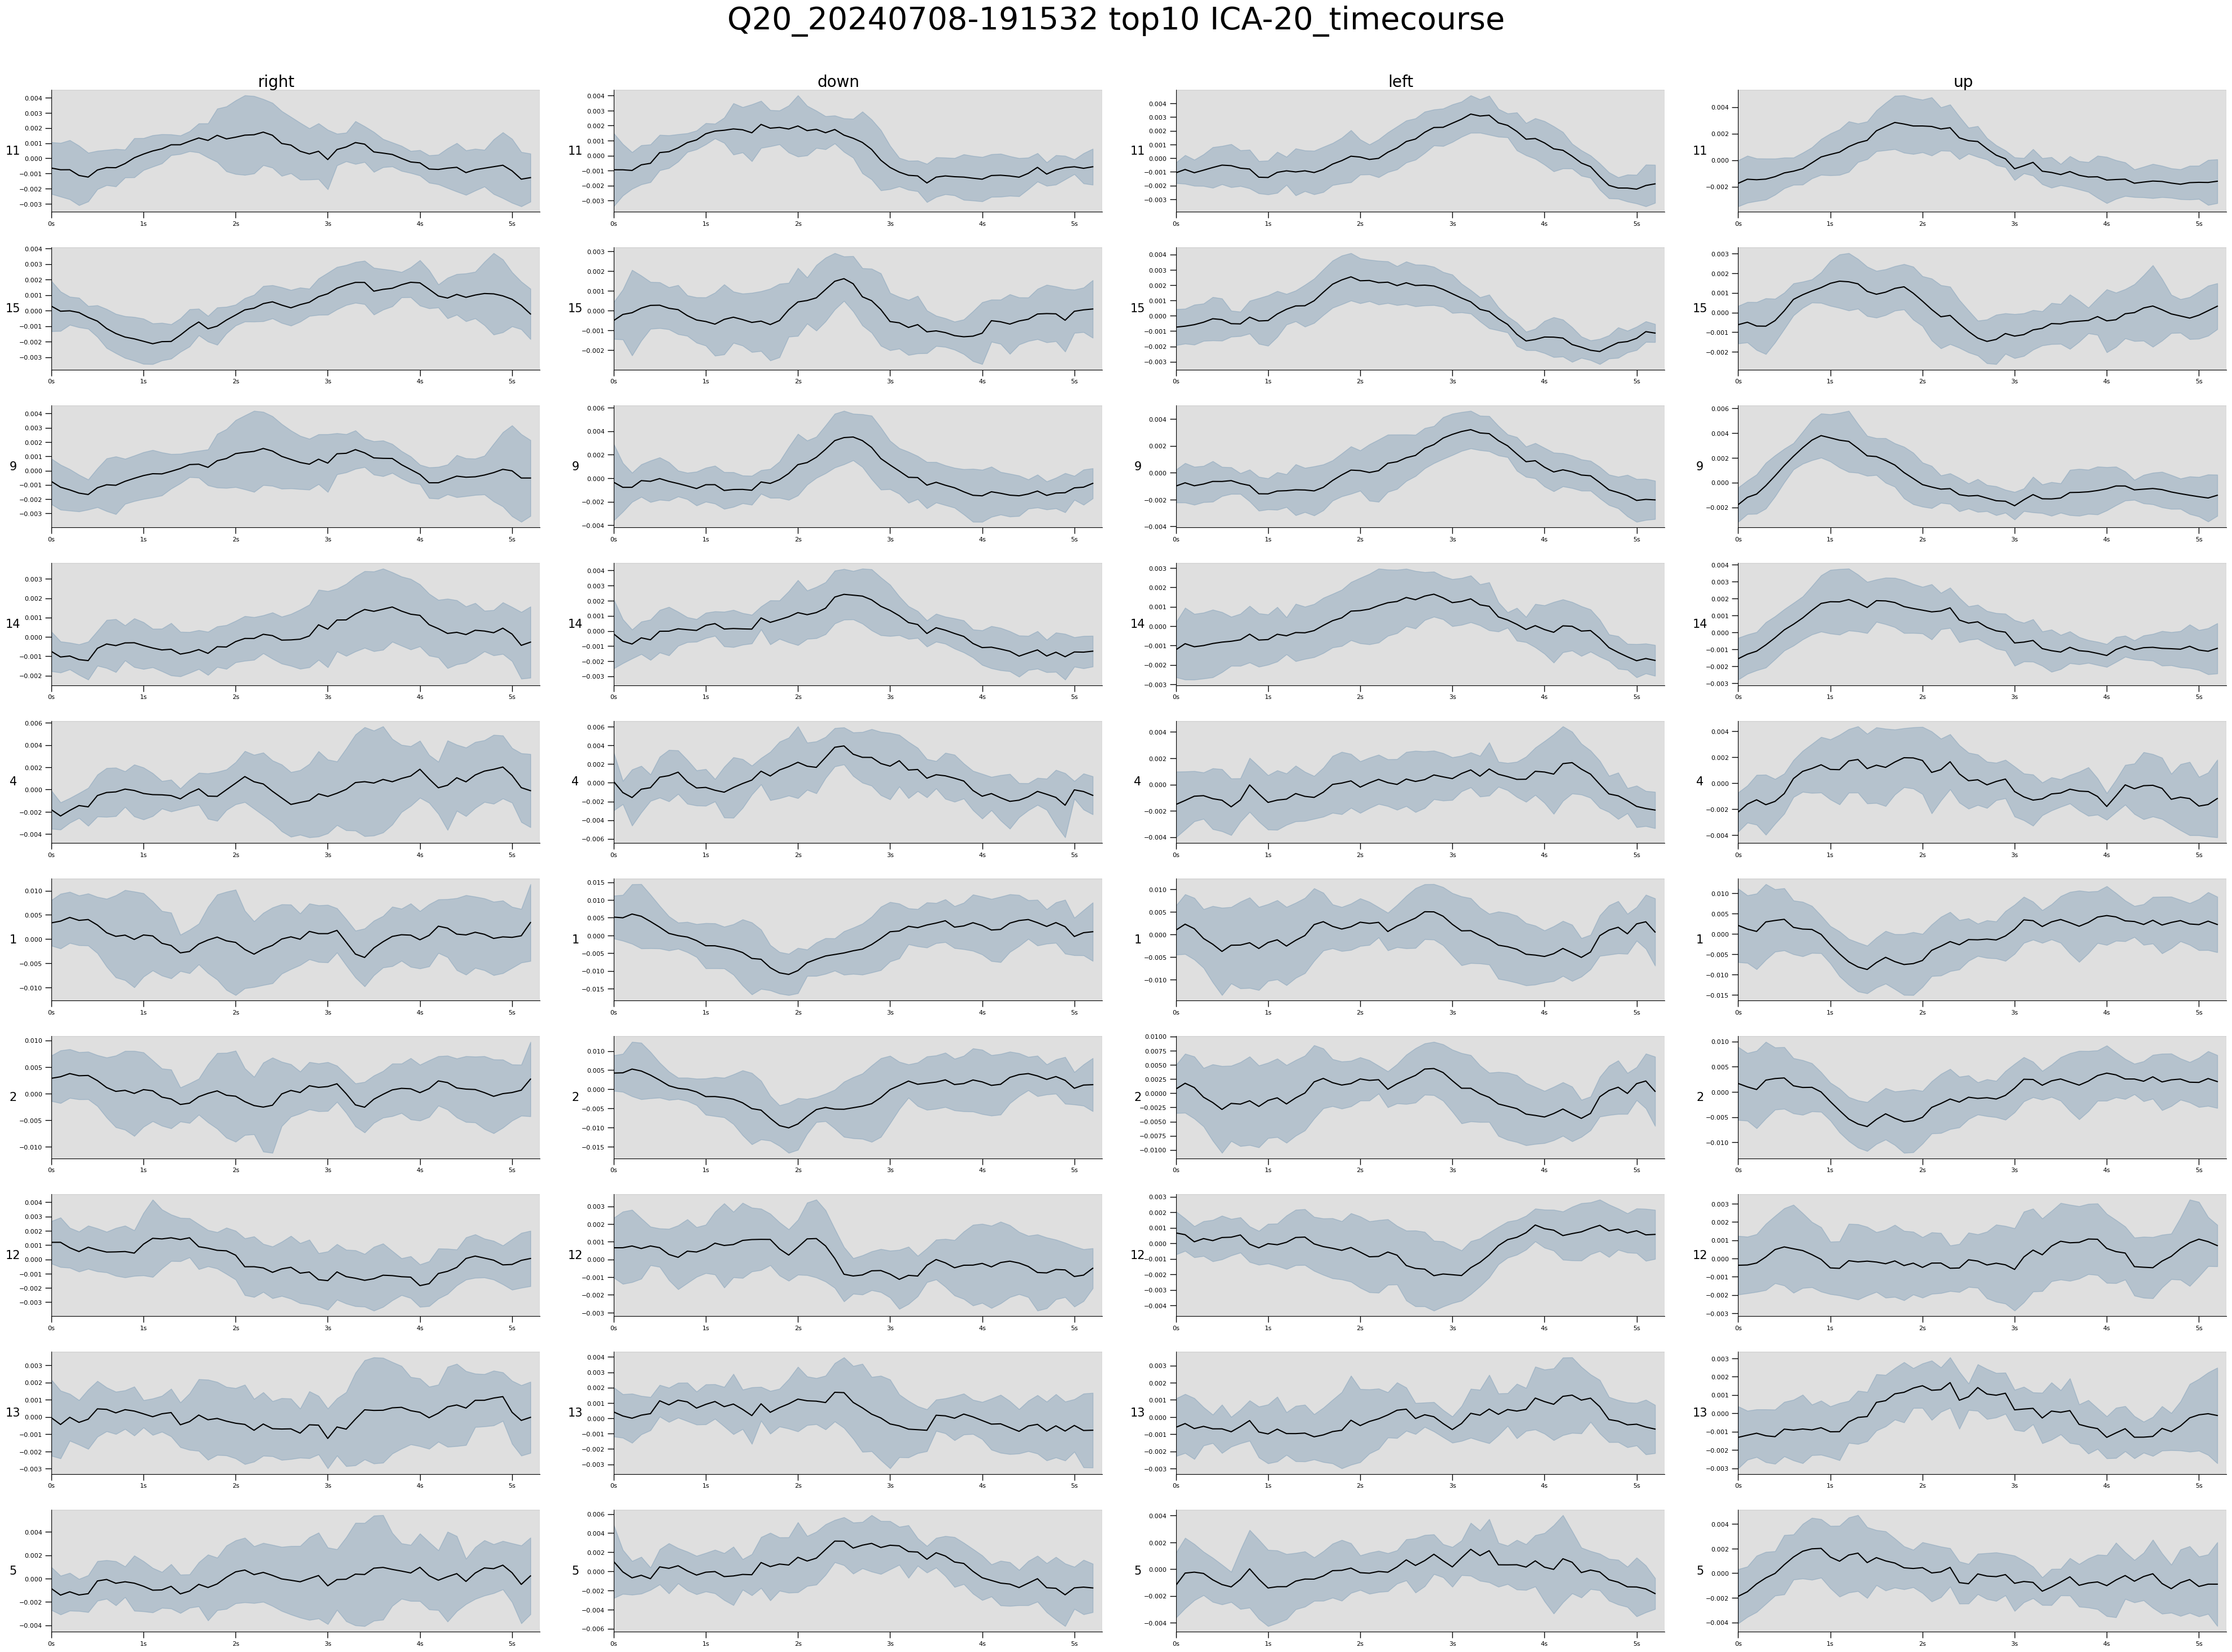

CPU times: user 10.6 s, sys: 151 ms, total: 10.7 s
Wall time: 10.8 s


In [39]:
%%time
subplot_timecourse(timecourse1, IC_idx+1, direction_list, title=f'{mouse}_{experiment} top10 ICA-{n_IC}_timecourse', outpath=path_out, pre_length=0, n_frame=stim_len, plot_rep=False, dpi=200)
